In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/2934 [00:01<56:09,  1.15s/it]

  0%|▎                                                                                                                                                     | 6/2934 [00:01<07:48,  6.25it/s]

  0%|▌                                                                                                                                                    | 11/2934 [00:01<04:04, 11.95it/s]

  1%|▊                                                                                                                                                    | 16/2934 [00:01<02:42, 17.92it/s]

  1%|█                                                                                                                                                    | 21/2934 [00:01<02:02, 23.81it/s]

  1%|█▎                                                                                                                                                   | 26/2934 [00:01<01:39, 29.23it/s]

  1%|█▌                                                                                                                                                   | 31/2934 [00:01<01:25, 33.92it/s]

  1%|█▊                                                                                                                                                   | 36/2934 [00:01<01:16, 37.81it/s]

  1%|██                                                                                                                                                   | 41/2934 [00:01<01:10, 40.92it/s]

  2%|██▎                                                                                                                                                  | 46/2934 [00:02<01:06, 43.33it/s]

  2%|██▌                                                                                                                                                  | 51/2934 [00:02<01:03, 45.11it/s]

  2%|██▊                                                                                                                                                  | 56/2934 [00:02<01:01, 46.43it/s]

  2%|███                                                                                                                                                  | 61/2934 [00:02<01:00, 47.37it/s]

  2%|███▎                                                                                                                                                 | 66/2934 [00:02<00:59, 47.97it/s]

  2%|███▌                                                                                                                                                 | 71/2934 [00:02<00:59, 48.48it/s]

  3%|███▊                                                                                                                                                 | 76/2934 [00:02<00:58, 48.86it/s]

  3%|████                                                                                                                                                 | 81/2934 [00:02<00:58, 49.14it/s]

  3%|████▎                                                                                                                                                | 86/2934 [00:02<00:57, 49.31it/s]

  3%|████▌                                                                                                                                                | 91/2934 [00:02<00:57, 49.44it/s]

  3%|████▉                                                                                                                                                | 96/2934 [00:03<00:57, 49.49it/s]

  3%|█████                                                                                                                                               | 101/2934 [00:03<00:57, 49.60it/s]

  4%|█████▎                                                                                                                                              | 106/2934 [00:03<00:56, 49.62it/s]

  4%|█████▌                                                                                                                                              | 111/2934 [00:03<00:56, 49.66it/s]

  4%|█████▊                                                                                                                                              | 116/2934 [00:03<00:56, 49.70it/s]

  4%|██████                                                                                                                                              | 121/2934 [00:03<00:56, 49.71it/s]

  4%|██████▎                                                                                                                                             | 126/2934 [00:03<00:56, 49.64it/s]

  4%|██████▌                                                                                                                                             | 131/2934 [00:03<00:56, 49.66it/s]

  5%|██████▊                                                                                                                                             | 136/2934 [00:03<00:56, 49.67it/s]

  5%|███████                                                                                                                                             | 141/2934 [00:03<00:56, 49.72it/s]

  5%|███████▎                                                                                                                                            | 146/2934 [00:04<00:56, 49.72it/s]

  5%|███████▌                                                                                                                                            | 151/2934 [00:04<00:56, 49.69it/s]

  5%|███████▊                                                                                                                                            | 156/2934 [00:04<00:55, 49.70it/s]

  5%|████████                                                                                                                                            | 161/2934 [00:04<00:55, 49.70it/s]

  6%|████████▎                                                                                                                                           | 166/2934 [00:04<00:55, 49.72it/s]

  6%|████████▋                                                                                                                                           | 171/2934 [00:04<00:55, 49.70it/s]

  6%|████████▉                                                                                                                                           | 176/2934 [00:04<00:55, 49.68it/s]

  6%|█████████▏                                                                                                                                          | 181/2934 [00:04<00:55, 49.63it/s]

  6%|█████████▍                                                                                                                                          | 186/2934 [00:04<00:55, 49.61it/s]

  7%|█████████▋                                                                                                                                          | 191/2934 [00:04<00:55, 49.63it/s]

  7%|█████████▉                                                                                                                                          | 196/2934 [00:05<00:55, 49.03it/s]

  7%|██████████▏                                                                                                                                         | 201/2934 [00:05<00:55, 49.20it/s]

  7%|██████████▍                                                                                                                                         | 206/2934 [00:05<00:55, 49.34it/s]

  7%|██████████▋                                                                                                                                         | 211/2934 [00:05<00:55, 49.46it/s]

  7%|██████████▉                                                                                                                                         | 216/2934 [00:05<00:54, 49.49it/s]

  8%|███████████▏                                                                                                                                        | 221/2934 [00:05<00:54, 49.55it/s]

  8%|███████████▍                                                                                                                                        | 226/2934 [00:05<00:54, 49.55it/s]

  8%|███████████▋                                                                                                                                        | 231/2934 [00:05<00:54, 49.60it/s]

  8%|███████████▉                                                                                                                                        | 236/2934 [00:05<00:54, 49.62it/s]

  8%|████████████▏                                                                                                                                       | 241/2934 [00:06<00:54, 49.52it/s]

  8%|████████████▍                                                                                                                                       | 246/2934 [00:06<00:54, 49.59it/s]

  9%|████████████▋                                                                                                                                       | 251/2934 [00:06<00:54, 49.58it/s]

  9%|████████████▉                                                                                                                                       | 256/2934 [00:06<00:53, 49.70it/s]

  9%|█████████████▏                                                                                                                                      | 261/2934 [00:06<00:53, 49.69it/s]

  9%|█████████████▍                                                                                                                                      | 266/2934 [00:06<00:53, 49.68it/s]

  9%|█████████████▋                                                                                                                                      | 271/2934 [00:06<00:53, 49.69it/s]

  9%|█████████████▉                                                                                                                                      | 276/2934 [00:06<00:53, 49.71it/s]

 10%|██████████████▏                                                                                                                                     | 281/2934 [00:06<00:53, 49.66it/s]

 10%|██████████████▍                                                                                                                                     | 286/2934 [00:06<00:53, 49.66it/s]

 10%|██████████████▋                                                                                                                                     | 291/2934 [00:07<00:53, 49.63it/s]

 10%|██████████████▉                                                                                                                                     | 296/2934 [00:07<00:53, 49.67it/s]

 10%|███████████████▏                                                                                                                                    | 301/2934 [00:07<00:52, 49.71it/s]

 10%|███████████████▍                                                                                                                                    | 306/2934 [00:07<00:52, 49.71it/s]

 11%|███████████████▋                                                                                                                                    | 311/2934 [00:07<00:52, 49.73it/s]

 11%|███████████████▉                                                                                                                                    | 316/2934 [00:07<00:52, 49.73it/s]

 11%|████████████████▏                                                                                                                                   | 321/2934 [00:07<00:52, 49.80it/s]

 11%|████████████████▍                                                                                                                                   | 326/2934 [00:07<00:52, 49.77it/s]

 11%|████████████████▋                                                                                                                                   | 331/2934 [00:07<00:52, 49.74it/s]

 11%|████████████████▉                                                                                                                                   | 336/2934 [00:07<00:52, 49.70it/s]

 12%|█████████████████▏                                                                                                                                  | 341/2934 [00:08<00:52, 49.64it/s]

 12%|█████████████████▍                                                                                                                                  | 346/2934 [00:08<00:52, 49.67it/s]

 12%|█████████████████▋                                                                                                                                  | 351/2934 [00:08<00:52, 49.60it/s]

 12%|█████████████████▉                                                                                                                                  | 356/2934 [00:08<00:51, 49.62it/s]

 12%|██████████████████▏                                                                                                                                 | 361/2934 [00:08<00:51, 49.54it/s]

 12%|██████████████████▍                                                                                                                                 | 366/2934 [00:08<00:51, 49.64it/s]

 13%|██████████████████▋                                                                                                                                 | 371/2934 [00:08<00:51, 49.65it/s]

 13%|██████████████████▉                                                                                                                                 | 376/2934 [00:08<00:51, 49.64it/s]

 13%|███████████████████▏                                                                                                                                | 381/2934 [00:08<00:51, 49.69it/s]

 13%|███████████████████▍                                                                                                                                | 386/2934 [00:08<00:51, 49.72it/s]

 13%|███████████████████▋                                                                                                                                | 391/2934 [00:09<00:51, 49.65it/s]

 13%|███████████████████▉                                                                                                                                | 396/2934 [00:09<00:51, 49.47it/s]

 14%|████████████████████▏                                                                                                                               | 401/2934 [00:09<00:51, 49.33it/s]

 14%|████████████████████▍                                                                                                                               | 406/2934 [00:09<00:51, 49.20it/s]

 14%|████████████████████▋                                                                                                                               | 411/2934 [00:09<00:51, 49.18it/s]

 14%|████████████████████▉                                                                                                                               | 416/2934 [00:09<00:51, 49.12it/s]

 14%|█████████████████████▏                                                                                                                              | 421/2934 [00:09<00:51, 49.09it/s]

 15%|█████████████████████▍                                                                                                                              | 426/2934 [00:09<00:51, 49.10it/s]

 15%|█████████████████████▋                                                                                                                              | 431/2934 [00:09<00:50, 49.15it/s]

 15%|█████████████████████▉                                                                                                                              | 436/2934 [00:09<00:50, 49.15it/s]

 15%|██████████████████████▏                                                                                                                             | 441/2934 [00:10<00:50, 49.12it/s]

 15%|██████████████████████▍                                                                                                                             | 446/2934 [00:10<00:50, 49.11it/s]

 15%|██████████████████████▋                                                                                                                             | 451/2934 [00:10<00:50, 49.09it/s]

 16%|███████████████████████                                                                                                                             | 456/2934 [00:10<00:50, 49.13it/s]

 16%|███████████████████████▎                                                                                                                            | 461/2934 [00:10<00:50, 49.07it/s]

 16%|███████████████████████▌                                                                                                                            | 466/2934 [00:10<00:50, 49.06it/s]

 16%|███████████████████████▊                                                                                                                            | 471/2934 [00:10<00:50, 49.00it/s]

 16%|████████████████████████                                                                                                                            | 476/2934 [00:10<00:50, 48.99it/s]

 16%|████████████████████████▎                                                                                                                           | 481/2934 [00:10<00:50, 49.03it/s]

 17%|████████████████████████▌                                                                                                                           | 486/2934 [00:10<00:49, 49.04it/s]

 17%|████████████████████████▊                                                                                                                           | 491/2934 [00:11<00:49, 49.13it/s]

 17%|█████████████████████████                                                                                                                           | 497/2934 [00:11<00:49, 49.69it/s]

 17%|█████████████████████████▎                                                                                                                          | 503/2934 [00:11<00:48, 49.93it/s]

 17%|█████████████████████████▋                                                                                                                          | 508/2934 [00:11<00:48, 49.87it/s]

 17%|█████████████████████████▉                                                                                                                          | 513/2934 [00:11<00:48, 49.85it/s]

 18%|██████████████████████████▏                                                                                                                         | 518/2934 [00:11<00:48, 49.59it/s]

 18%|██████████████████████████▍                                                                                                                         | 523/2934 [00:11<00:48, 49.32it/s]

 18%|██████████████████████████▋                                                                                                                         | 528/2934 [00:11<00:48, 49.14it/s]

 18%|██████████████████████████▉                                                                                                                         | 533/2934 [00:11<00:48, 49.05it/s]

 18%|███████████████████████████▏                                                                                                                        | 538/2934 [00:12<00:48, 49.06it/s]

 19%|███████████████████████████▍                                                                                                                        | 543/2934 [00:12<00:48, 49.07it/s]

 19%|███████████████████████████▋                                                                                                                        | 548/2934 [00:12<00:48, 49.04it/s]

 19%|███████████████████████████▉                                                                                                                        | 553/2934 [00:12<00:48, 49.02it/s]

 19%|████████████████████████████▏                                                                                                                       | 558/2934 [00:12<00:48, 49.05it/s]

 19%|████████████████████████████▍                                                                                                                       | 563/2934 [00:12<00:48, 49.03it/s]

 19%|████████████████████████████▋                                                                                                                       | 568/2934 [00:12<00:48, 48.98it/s]

 20%|████████████████████████████▉                                                                                                                       | 573/2934 [00:12<00:48, 48.99it/s]

 20%|█████████████████████████████▏                                                                                                                      | 578/2934 [00:12<00:48, 49.03it/s]

 20%|█████████████████████████████▍                                                                                                                      | 583/2934 [00:12<00:47, 49.06it/s]

 20%|█████████████████████████████▋                                                                                                                      | 588/2934 [00:13<00:47, 49.05it/s]

 20%|█████████████████████████████▉                                                                                                                      | 593/2934 [00:13<00:47, 49.10it/s]

 20%|██████████████████████████████▏                                                                                                                     | 598/2934 [00:13<00:47, 49.10it/s]

 21%|██████████████████████████████▍                                                                                                                     | 603/2934 [00:13<00:47, 49.08it/s]

 21%|██████████████████████████████▋                                                                                                                     | 608/2934 [00:13<00:47, 49.09it/s]

 21%|██████████████████████████████▉                                                                                                                     | 613/2934 [00:13<00:47, 49.08it/s]

 21%|███████████████████████████████▏                                                                                                                    | 618/2934 [00:13<00:47, 49.05it/s]

 21%|███████████████████████████████▍                                                                                                                    | 623/2934 [00:13<00:47, 49.04it/s]

 21%|███████████████████████████████▋                                                                                                                    | 628/2934 [00:13<00:47, 49.02it/s]

 22%|███████████████████████████████▉                                                                                                                    | 633/2934 [00:13<00:46, 49.03it/s]

 22%|████████████████████████████████▏                                                                                                                   | 638/2934 [00:14<00:46, 48.91it/s]

 22%|████████████████████████████████▍                                                                                                                   | 643/2934 [00:14<00:46, 48.95it/s]

 22%|████████████████████████████████▋                                                                                                                   | 648/2934 [00:14<00:46, 49.02it/s]

 22%|████████████████████████████████▉                                                                                                                   | 654/2934 [00:14<00:46, 49.54it/s]

 22%|█████████████████████████████████▎                                                                                                                  | 660/2934 [00:14<00:45, 49.86it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 666/2934 [00:14<00:45, 49.91it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 672/2934 [00:14<00:45, 50.10it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 678/2934 [00:14<00:44, 50.22it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 684/2934 [00:14<00:44, 50.32it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 690/2934 [00:15<00:44, 50.24it/s]

 24%|███████████████████████████████████                                                                                                                 | 696/2934 [00:15<00:44, 50.33it/s]

 24%|███████████████████████████████████▍                                                                                                                | 702/2934 [00:15<00:44, 50.37it/s]

 24%|███████████████████████████████████▋                                                                                                                | 708/2934 [00:15<00:44, 50.28it/s]

 24%|████████████████████████████████████                                                                                                                | 714/2934 [00:15<00:44, 50.33it/s]

 25%|████████████████████████████████████▎                                                                                                               | 720/2934 [00:15<00:43, 50.38it/s]

 25%|████████████████████████████████████▌                                                                                                               | 726/2934 [00:15<00:43, 50.27it/s]

 25%|████████████████████████████████████▉                                                                                                               | 732/2934 [00:15<00:43, 50.16it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 738/2934 [00:16<00:43, 50.25it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 744/2934 [00:16<00:43, 50.21it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 750/2934 [00:16<00:43, 50.23it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 756/2934 [00:16<00:43, 50.32it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 762/2934 [00:16<00:43, 50.27it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 768/2934 [00:16<00:43, 50.36it/s]

 26%|███████████████████████████████████████                                                                                                             | 774/2934 [00:16<00:42, 50.39it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 780/2934 [00:16<00:42, 50.38it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 786/2934 [00:17<00:42, 50.27it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 792/2934 [00:17<00:42, 50.30it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 798/2934 [00:17<00:42, 50.34it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 804/2934 [00:17<00:42, 50.24it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 810/2934 [00:17<00:42, 50.27it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 816/2934 [00:17<00:42, 50.30it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 822/2934 [00:17<00:42, 50.11it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 828/2934 [00:17<00:41, 50.24it/s]

 28%|██████████████████████████████████████████                                                                                                          | 834/2934 [00:17<00:41, 50.25it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 840/2934 [00:18<00:41, 50.18it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 846/2934 [00:18<00:41, 50.27it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 852/2934 [00:18<00:41, 50.29it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 858/2934 [00:18<00:41, 50.22it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 864/2934 [00:18<00:41, 50.31it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 870/2934 [00:18<00:40, 50.35it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 876/2934 [00:18<00:40, 50.39it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 882/2934 [00:18<00:40, 50.25it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 888/2934 [00:19<00:40, 50.29it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 894/2934 [00:19<00:40, 50.37it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 900/2934 [00:19<00:40, 50.29it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 906/2934 [00:19<00:40, 50.34it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 912/2934 [00:19<00:40, 50.37it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 918/2934 [00:19<00:40, 50.31it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 924/2934 [00:19<00:40, 50.19it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 930/2934 [00:19<00:39, 50.25it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 936/2934 [00:19<00:39, 50.23it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 942/2934 [00:20<00:39, 50.29it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 948/2934 [00:20<00:39, 50.34it/s]

 33%|████████████████████████████████████████████████                                                                                                    | 954/2934 [00:20<00:39, 50.37it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 960/2934 [00:20<00:39, 50.26it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 966/2934 [00:20<00:39, 50.32it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 972/2934 [00:20<00:38, 50.36it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 978/2934 [00:20<00:38, 50.41it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 984/2934 [00:20<00:38, 50.30it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 990/2934 [00:21<00:38, 50.38it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 996/2934 [00:21<00:38, 50.40it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 1002/2934 [00:21<00:38, 50.27it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                | 1008/2934 [00:21<00:38, 50.29it/s]

 35%|██████████████████████████████████████████████████▊                                                                                                | 1014/2934 [00:21<00:38, 50.31it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 1020/2934 [00:21<00:38, 50.21it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 1026/2934 [00:21<00:38, 50.20it/s]

 35%|███████████████████████████████████████████████████▋                                                                                               | 1032/2934 [00:21<00:37, 50.19it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 1038/2934 [00:22<00:37, 50.02it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 1044/2934 [00:22<00:37, 49.75it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 1049/2934 [00:22<00:38, 49.36it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 1054/2934 [00:22<00:38, 49.04it/s]

 36%|█████████████████████████████████████████████████████                                                                                              | 1059/2934 [00:22<00:38, 48.87it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 1064/2934 [00:22<00:38, 48.79it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                             | 1069/2934 [00:22<00:38, 48.73it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 1074/2934 [00:22<00:38, 48.74it/s]

 37%|██████████████████████████████████████████████████████                                                                                             | 1079/2934 [00:22<00:38, 48.77it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 1084/2934 [00:22<00:37, 48.79it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 1089/2934 [00:23<00:37, 48.88it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 1094/2934 [00:23<00:37, 48.86it/s]

 37%|███████████████████████████████████████████████████████                                                                                            | 1099/2934 [00:23<00:37, 48.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                           | 1104/2934 [00:23<00:37, 48.87it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 1109/2934 [00:23<00:37, 48.94it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 1114/2934 [00:23<00:37, 49.01it/s]

 38%|████████████████████████████████████████████████████████                                                                                           | 1119/2934 [00:23<00:36, 49.07it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                          | 1124/2934 [00:23<00:36, 49.06it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1129/2934 [00:23<00:36, 49.06it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1134/2934 [00:23<00:36, 49.12it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1139/2934 [00:24<00:36, 49.08it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1144/2934 [00:24<00:36, 49.15it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1149/2934 [00:24<00:36, 49.02it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1154/2934 [00:24<00:36, 49.01it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 1159/2934 [00:24<00:36, 49.03it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1164/2934 [00:24<00:36, 49.09it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1169/2934 [00:24<00:36, 48.99it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1174/2934 [00:24<00:35, 49.03it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1179/2934 [00:24<00:35, 49.07it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1184/2934 [00:24<00:35, 48.99it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1189/2934 [00:25<00:35, 48.92it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1194/2934 [00:25<00:35, 48.93it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1199/2934 [00:25<00:35, 48.91it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1204/2934 [00:25<00:35, 48.98it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1209/2934 [00:25<00:35, 49.06it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1214/2934 [00:25<00:35, 49.04it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1219/2934 [00:25<00:34, 49.07it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1224/2934 [00:25<00:34, 49.09it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1229/2934 [00:25<00:34, 49.10it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1234/2934 [00:26<00:34, 49.10it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1239/2934 [00:26<00:34, 49.09it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1244/2934 [00:26<00:34, 49.13it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1249/2934 [00:26<00:34, 49.08it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1254/2934 [00:26<00:34, 48.89it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1259/2934 [00:26<00:34, 48.95it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1264/2934 [00:26<00:34, 48.96it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1269/2934 [00:26<00:33, 48.99it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1274/2934 [00:26<00:33, 49.07it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1279/2934 [00:26<00:33, 49.09it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1284/2934 [00:27<00:33, 49.06it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1289/2934 [00:27<00:33, 48.99it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1294/2934 [00:27<00:33, 48.95it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1299/2934 [00:27<00:33, 48.93it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1304/2934 [00:27<00:33, 49.00it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1309/2934 [00:27<00:33, 49.04it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1314/2934 [00:27<00:33, 48.93it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1319/2934 [00:27<00:33, 48.94it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1324/2934 [00:27<00:32, 48.96it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1329/2934 [00:27<00:32, 49.03it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1334/2934 [00:28<00:32, 49.05it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1339/2934 [00:28<00:32, 49.14it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1344/2934 [00:28<00:32, 49.16it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1349/2934 [00:28<00:32, 49.21it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1354/2934 [00:28<00:32, 49.20it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1359/2934 [00:28<00:32, 48.95it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1364/2934 [00:28<00:32, 48.97it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1369/2934 [00:28<00:31, 49.03it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1374/2934 [00:28<00:31, 49.08it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1379/2934 [00:28<00:31, 49.14it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1384/2934 [00:29<00:31, 49.17it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1389/2934 [00:29<00:31, 49.07it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1394/2934 [00:29<00:31, 48.99it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1399/2934 [00:29<00:31, 49.05it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1404/2934 [00:29<00:31, 49.12it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1409/2934 [00:29<00:31, 49.11it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1414/2934 [00:29<00:30, 49.16it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1419/2934 [00:29<00:30, 49.08it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1424/2934 [00:29<00:30, 49.04it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1429/2934 [00:29<00:30, 49.05it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1434/2934 [00:30<00:30, 48.96it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1439/2934 [00:30<00:30, 48.89it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1444/2934 [00:30<00:30, 48.89it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1449/2934 [00:30<00:30, 48.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1454/2934 [00:30<00:30, 48.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1459/2934 [00:30<00:30, 49.01it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1464/2934 [00:30<00:29, 49.10it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1469/2934 [00:30<00:29, 49.16it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1474/2934 [00:30<00:29, 49.04it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1479/2934 [00:31<00:29, 48.97it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1484/2934 [00:31<00:29, 49.03it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1489/2934 [00:31<00:29, 49.05it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1494/2934 [00:31<00:29, 48.97it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1499/2934 [00:31<00:29, 48.95it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1504/2934 [00:31<00:29, 48.99it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1509/2934 [00:31<00:29, 49.05it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1514/2934 [00:31<00:28, 49.11it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1519/2934 [00:31<00:28, 49.10it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1524/2934 [00:31<00:28, 48.92it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1529/2934 [00:32<00:28, 48.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1534/2934 [00:32<00:28, 48.72it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1539/2934 [00:32<00:28, 48.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1544/2934 [00:32<00:28, 48.93it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1549/2934 [00:32<00:28, 49.02it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1554/2934 [00:32<00:28, 49.07it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1559/2934 [00:32<00:28, 48.99it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1564/2934 [00:32<00:27, 48.94it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1569/2934 [00:32<00:27, 48.96it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1574/2934 [00:32<00:27, 48.97it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1579/2934 [00:33<00:27, 49.02it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1584/2934 [00:33<00:27, 49.04it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1589/2934 [00:33<00:27, 49.01it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1594/2934 [00:33<00:27, 49.02it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1599/2934 [00:33<00:27, 48.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1604/2934 [00:33<00:27, 48.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1609/2934 [00:33<00:27, 48.99it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1614/2934 [00:33<00:26, 49.02it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1619/2934 [00:33<00:26, 49.05it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1624/2934 [00:33<00:26, 49.06it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1629/2934 [00:34<00:26, 49.13it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1634/2934 [00:34<00:26, 49.11it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1639/2934 [00:34<00:26, 49.09it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1644/2934 [00:34<00:26, 49.12it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1649/2934 [00:34<00:26, 49.08it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1654/2934 [00:34<00:26, 49.10it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1659/2934 [00:34<00:25, 49.18it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1664/2934 [00:34<00:25, 48.92it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1669/2934 [00:34<00:25, 49.21it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1674/2934 [00:34<00:25, 49.14it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1679/2934 [00:35<00:25, 49.14it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1684/2934 [00:35<00:25, 49.19it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1689/2934 [00:35<00:25, 49.11it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1694/2934 [00:35<00:25, 49.05it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1699/2934 [00:35<00:25, 49.05it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1704/2934 [00:35<00:25, 49.10it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1709/2934 [00:35<00:24, 49.13it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1714/2934 [00:35<00:24, 49.20it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1719/2934 [00:35<00:24, 49.22it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1724/2934 [00:36<00:24, 49.09it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1729/2934 [00:36<00:24, 49.07it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1734/2934 [00:36<00:24, 49.08it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1739/2934 [00:36<00:24, 49.09it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1744/2934 [00:36<00:24, 49.13it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1749/2934 [00:36<00:24, 49.17it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1754/2934 [00:36<00:24, 49.17it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1759/2934 [00:36<00:23, 49.20it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1764/2934 [00:36<00:23, 49.08it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1769/2934 [00:36<00:23, 49.01it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1774/2934 [00:37<00:23, 49.00it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1779/2934 [00:37<00:23, 48.98it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1784/2934 [00:37<00:23, 49.09it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1789/2934 [00:37<00:23, 49.13it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1794/2934 [00:37<00:23, 49.11it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1799/2934 [00:37<00:23, 49.02it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1804/2934 [00:37<00:23, 48.91it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1809/2934 [00:37<00:22, 48.91it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1814/2934 [00:37<00:22, 48.94it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1819/2934 [00:37<00:22, 48.98it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1824/2934 [00:38<00:22, 49.09it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1829/2934 [00:38<00:22, 49.11it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1834/2934 [00:38<00:22, 49.11it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1839/2934 [00:38<00:22, 48.85it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1844/2934 [00:38<00:22, 48.86it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1849/2934 [00:38<00:22, 48.95it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1854/2934 [00:38<00:22, 49.00it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1859/2934 [00:38<00:21, 49.09it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1864/2934 [00:38<00:21, 49.16it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1869/2934 [00:38<00:21, 49.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1874/2934 [00:39<00:21, 48.92it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1879/2934 [00:39<00:21, 49.10it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1884/2934 [00:39<00:21, 49.23it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1889/2934 [00:39<00:21, 49.22it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1894/2934 [00:39<00:21, 49.25it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1899/2934 [00:39<00:21, 49.24it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1904/2934 [00:39<00:20, 49.26it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1909/2934 [00:39<00:20, 49.27it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1914/2934 [00:39<00:20, 49.16it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1919/2934 [00:39<00:20, 49.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1924/2934 [00:40<00:20, 49.18it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1929/2934 [00:40<00:20, 49.19it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1934/2934 [00:40<00:20, 49.23it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1939/2934 [00:40<00:20, 49.16it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1944/2934 [00:40<00:20, 49.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1949/2934 [00:40<00:20, 49.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1954/2934 [00:40<00:19, 49.07it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1959/2934 [00:40<00:19, 49.10it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1964/2934 [00:40<00:19, 49.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1969/2934 [00:41<00:19, 49.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1974/2934 [00:41<00:19, 49.17it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1979/2934 [00:41<00:19, 49.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1984/2934 [00:41<00:19, 49.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1989/2934 [00:41<00:19, 49.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1994/2934 [00:41<00:19, 49.08it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1999/2934 [00:41<00:19, 49.00it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2004/2934 [00:41<00:18, 49.05it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2009/2934 [00:41<00:18, 49.09it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2014/2934 [00:41<00:18, 49.12it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2019/2934 [00:42<00:18, 49.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2024/2934 [00:42<00:18, 49.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2029/2934 [00:42<00:18, 49.07it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2034/2934 [00:42<00:18, 49.09it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2039/2934 [00:42<00:18, 49.15it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2044/2934 [00:42<00:18, 49.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2049/2934 [00:42<00:17, 49.20it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2054/2934 [00:42<00:17, 49.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2059/2934 [00:42<00:17, 49.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2064/2934 [00:42<00:17, 48.99it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2069/2934 [00:43<00:17, 49.05it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2074/2934 [00:43<00:17, 49.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2079/2934 [00:43<00:17, 49.09it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2084/2934 [00:43<00:17, 49.12it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2089/2934 [00:43<00:17, 49.13it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2094/2934 [00:43<00:17, 49.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2099/2934 [00:43<00:16, 49.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2104/2934 [00:43<00:16, 49.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2109/2934 [00:43<00:16, 48.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2114/2934 [00:43<00:16, 49.04it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2119/2934 [00:44<00:16, 49.09it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2124/2934 [00:44<00:16, 49.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2129/2934 [00:44<00:16, 49.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2134/2934 [00:44<00:16, 49.20it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2139/2934 [00:44<00:16, 49.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2144/2934 [00:44<00:16, 49.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2149/2934 [00:44<00:15, 49.17it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2154/2934 [00:44<00:15, 49.21it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2159/2934 [00:44<00:15, 49.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2164/2934 [00:44<00:15, 49.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2169/2934 [00:45<00:15, 49.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2174/2934 [00:45<00:15, 49.15it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2179/2934 [00:45<00:15, 49.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2184/2934 [00:45<00:15, 49.10it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2189/2934 [00:45<00:15, 49.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2194/2934 [00:45<00:15, 49.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2199/2934 [00:45<00:14, 49.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2204/2934 [00:45<00:14, 49.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2209/2934 [00:45<00:14, 49.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2214/2934 [00:45<00:14, 48.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2219/2934 [00:46<00:14, 48.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2224/2934 [00:46<00:14, 48.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2229/2934 [00:46<00:14, 48.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2234/2934 [00:46<00:14, 48.96it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2239/2934 [00:46<00:14, 49.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2244/2934 [00:46<00:14, 49.11it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2249/2934 [00:46<00:13, 49.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2254/2934 [00:46<00:13, 49.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2259/2934 [00:46<00:13, 49.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2264/2934 [00:47<00:13, 49.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2269/2934 [00:47<00:13, 49.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2274/2934 [00:47<00:13, 49.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2279/2934 [00:47<00:13, 49.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2284/2934 [00:47<00:13, 49.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2289/2934 [00:47<00:13, 48.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2294/2934 [00:47<00:13, 48.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2299/2934 [00:47<00:12, 49.02it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2304/2934 [00:47<00:12, 49.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2309/2934 [00:47<00:12, 49.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2314/2934 [00:48<00:12, 49.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2319/2934 [00:48<00:12, 49.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2324/2934 [00:48<00:12, 49.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2329/2934 [00:48<00:12, 48.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2334/2934 [00:48<00:12, 48.99it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2339/2934 [00:48<00:12, 49.02it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2344/2934 [00:48<00:12, 49.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2349/2934 [00:48<00:11, 49.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2354/2934 [00:48<00:11, 49.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2359/2934 [00:48<00:11, 49.10it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2364/2934 [00:49<00:11, 49.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2369/2934 [00:49<00:11, 48.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2374/2934 [00:49<00:11, 48.35it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2379/2934 [00:49<00:11, 48.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2384/2934 [00:49<00:11, 48.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2389/2934 [00:49<00:11, 47.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2394/2934 [00:49<00:11, 47.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2399/2934 [00:49<00:11, 47.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2404/2934 [00:49<00:11, 47.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2409/2934 [00:49<00:10, 47.74it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2414/2934 [00:50<00:10, 47.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2419/2934 [00:50<00:10, 47.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2424/2934 [00:50<00:10, 47.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2429/2934 [00:50<00:10, 47.76it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2434/2934 [00:50<00:10, 47.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2439/2934 [00:50<00:10, 47.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2444/2934 [00:50<00:10, 47.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2449/2934 [00:50<00:10, 47.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2454/2934 [00:50<00:10, 47.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2459/2934 [00:51<00:09, 47.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2464/2934 [00:51<00:09, 47.72it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2469/2934 [00:51<00:09, 47.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2474/2934 [00:51<00:09, 47.70it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2479/2934 [00:51<00:09, 47.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2484/2934 [00:51<00:09, 47.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2489/2934 [00:51<00:09, 47.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2494/2934 [00:51<00:09, 47.78it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2499/2934 [00:51<00:09, 47.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2504/2934 [00:51<00:08, 47.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2509/2934 [00:52<00:08, 47.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2514/2934 [00:52<00:08, 47.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2519/2934 [00:52<00:08, 47.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2524/2934 [00:52<00:08, 47.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2529/2934 [00:52<00:08, 47.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2534/2934 [00:52<00:08, 47.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2539/2934 [00:52<00:08, 47.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2544/2934 [00:52<00:08, 47.70it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2549/2934 [00:52<00:08, 47.72it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2554/2934 [00:53<00:07, 47.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2559/2934 [00:53<00:07, 47.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2564/2934 [00:53<00:07, 47.74it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2569/2934 [00:53<00:07, 47.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2574/2934 [00:53<00:07, 47.61it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2579/2934 [00:53<00:07, 47.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2584/2934 [00:53<00:07, 47.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2589/2934 [00:53<00:07, 47.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2594/2934 [00:53<00:07, 47.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2599/2934 [00:53<00:07, 47.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2604/2934 [00:54<00:06, 47.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2609/2934 [00:54<00:06, 47.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2614/2934 [00:54<00:06, 47.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2619/2934 [00:54<00:06, 47.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2624/2934 [00:54<00:06, 47.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2629/2934 [00:54<00:06, 47.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2634/2934 [00:54<00:06, 47.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2639/2934 [00:54<00:06, 47.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2644/2934 [00:54<00:06, 47.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2649/2934 [00:55<00:05, 47.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2654/2934 [00:55<00:05, 47.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2659/2934 [00:55<00:05, 47.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2664/2934 [00:55<00:05, 47.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2669/2934 [00:55<00:05, 47.62it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2674/2934 [00:55<00:05, 47.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2679/2934 [00:55<00:05, 47.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2684/2934 [00:55<00:05, 47.58it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2689/2934 [00:55<00:05, 47.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2694/2934 [00:55<00:05, 47.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2699/2934 [00:56<00:04, 47.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2704/2934 [00:56<00:04, 47.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2709/2934 [00:56<00:04, 47.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2714/2934 [00:56<00:04, 47.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2719/2934 [00:56<00:04, 47.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2724/2934 [00:56<00:04, 47.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2729/2934 [00:56<00:04, 47.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2734/2934 [00:56<00:04, 47.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2739/2934 [00:56<00:04, 47.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2744/2934 [00:57<00:03, 47.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2749/2934 [00:57<00:03, 47.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2754/2934 [00:57<00:03, 47.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2759/2934 [00:57<00:03, 47.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2764/2934 [00:57<00:03, 47.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2769/2934 [00:57<00:03, 47.69it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2774/2934 [00:57<00:03, 47.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2779/2934 [00:57<00:03, 47.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2784/2934 [00:57<00:03, 47.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2789/2934 [00:57<00:03, 47.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2794/2934 [00:58<00:02, 47.83it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2799/2934 [00:58<00:02, 47.77it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2804/2934 [00:58<00:02, 47.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2809/2934 [00:58<00:02, 47.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2814/2934 [00:58<00:02, 47.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2819/2934 [00:58<00:02, 47.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2824/2934 [00:58<00:02, 47.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2829/2934 [00:58<00:02, 47.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2834/2934 [00:58<00:02, 47.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2839/2934 [00:58<00:01, 47.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2844/2934 [00:59<00:01, 47.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2849/2934 [00:59<00:01, 47.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2854/2934 [00:59<00:01, 47.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2859/2934 [00:59<00:01, 47.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2864/2934 [00:59<00:01, 47.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2869/2934 [00:59<00:01, 47.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2874/2934 [00:59<00:01, 47.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2879/2934 [00:59<00:01, 47.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2884/2934 [00:59<00:01, 47.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2889/2934 [01:00<00:00, 47.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2894/2934 [01:00<00:00, 47.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2899/2934 [01:00<00:00, 47.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2904/2934 [01:00<00:00, 47.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2909/2934 [01:00<00:00, 47.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2914/2934 [01:00<00:00, 47.79it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2919/2934 [01:00<00:00, 47.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2924/2934 [01:00<00:00, 47.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2929/2934 [01:00<00:00, 45.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:01<00:00, 43.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:01<00:00, 48.05it/s]

train - OK


  0%|                                                                                                                                                               | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/380 [00:00<01:59,  3.18it/s]

  2%|██▍                                                                                                                                                    | 6/380 [00:00<00:21, 17.22it/s]

  3%|████▎                                                                                                                                                 | 11/380 [00:00<00:13, 26.58it/s]

  4%|██████▎                                                                                                                                               | 16/380 [00:00<00:11, 32.92it/s]

  6%|████████▎                                                                                                                                             | 21/380 [00:00<00:09, 37.28it/s]

  7%|██████████▎                                                                                                                                           | 26/380 [00:00<00:08, 39.98it/s]

  8%|████████████▏                                                                                                                                         | 31/380 [00:00<00:08, 42.03it/s]

  9%|██████████████▏                                                                                                                                       | 36/380 [00:01<00:07, 43.52it/s]

 11%|████████████████▏                                                                                                                                     | 41/380 [00:01<00:07, 44.53it/s]

 12%|██████████████████▏                                                                                                                                   | 46/380 [00:01<00:07, 45.29it/s]

 13%|████████████████████▏                                                                                                                                 | 51/380 [00:01<00:07, 45.48it/s]

 15%|██████████████████████                                                                                                                                | 56/380 [00:01<00:07, 45.88it/s]

 16%|████████████████████████                                                                                                                              | 61/380 [00:01<00:06, 46.42it/s]

 17%|██████████████████████████                                                                                                                            | 66/380 [00:01<00:06, 46.92it/s]

 19%|████████████████████████████                                                                                                                          | 71/380 [00:01<00:06, 47.07it/s]

 20%|██████████████████████████████                                                                                                                        | 76/380 [00:01<00:06, 47.16it/s]

 21%|███████████████████████████████▉                                                                                                                      | 81/380 [00:02<00:06, 47.40it/s]

 23%|█████████████████████████████████▉                                                                                                                    | 86/380 [00:02<00:06, 47.57it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 91/380 [00:02<00:06, 47.67it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 96/380 [00:02<00:05, 47.45it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 101/380 [00:02<00:05, 47.68it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 106/380 [00:02<00:05, 47.66it/s]

 29%|███████████████████████████████████████████▌                                                                                                         | 111/380 [00:02<00:05, 47.80it/s]

 31%|█████████████████████████████████████████████▍                                                                                                       | 116/380 [00:02<00:05, 47.80it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 121/380 [00:02<00:05, 47.54it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                   | 126/380 [00:02<00:05, 47.76it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 131/380 [00:03<00:05, 47.85it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 136/380 [00:03<00:05, 47.92it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 141/380 [00:03<00:05, 47.69it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 146/380 [00:03<00:04, 47.70it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 151/380 [00:03<00:04, 47.84it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 156/380 [00:03<00:04, 47.87it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 161/380 [00:03<00:04, 47.93it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 166/380 [00:03<00:04, 47.62it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 171/380 [00:03<00:04, 47.72it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 176/380 [00:04<00:04, 47.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 181/380 [00:04<00:04, 47.88it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 186/380 [00:04<00:04, 47.74it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 191/380 [00:04<00:03, 47.65it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 196/380 [00:04<00:03, 47.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 201/380 [00:04<00:03, 47.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 206/380 [00:04<00:03, 47.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/380 [00:04<00:03, 47.60it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 216/380 [00:04<00:03, 47.75it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 221/380 [00:04<00:03, 47.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 226/380 [00:05<00:03, 47.93it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 231/380 [00:05<00:03, 47.85it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 236/380 [00:05<00:03, 47.63it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 241/380 [00:05<00:02, 47.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 246/380 [00:05<00:02, 48.01it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 251/380 [00:05<00:02, 47.98it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 256/380 [00:05<00:02, 47.62it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 261/380 [00:05<00:02, 47.77it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 266/380 [00:05<00:02, 47.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 271/380 [00:05<00:02, 48.01it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 276/380 [00:06<00:02, 48.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 281/380 [00:06<00:02, 47.69it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 286/380 [00:06<00:01, 47.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 291/380 [00:06<00:01, 47.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 296/380 [00:06<00:01, 48.03it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 301/380 [00:06<00:01, 47.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 306/380 [00:06<00:01, 47.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 311/380 [00:06<00:01, 47.70it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 316/380 [00:06<00:01, 47.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 321/380 [00:07<00:01, 47.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 326/380 [00:07<00:01, 48.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 331/380 [00:07<00:01, 47.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 336/380 [00:07<00:00, 47.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 341/380 [00:07<00:00, 47.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 346/380 [00:07<00:00, 47.92it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 351/380 [00:07<00:00, 48.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 356/380 [00:07<00:00, 47.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 361/380 [00:07<00:00, 47.38it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 366/380 [00:07<00:00, 47.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 371/380 [00:08<00:00, 47.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [00:08<00:00, 47.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 45.14it/s]

val - OK


  0%|                                                                                                                                                               | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                      | 1/161 [00:00<00:56,  2.84it/s]

  4%|█████▋                                                                                                                                                 | 6/161 [00:00<00:09, 15.93it/s]

  7%|██████████▏                                                                                                                                           | 11/161 [00:00<00:05, 25.21it/s]

 10%|██████████████▉                                                                                                                                       | 16/161 [00:00<00:04, 31.64it/s]

 13%|███████████████████▌                                                                                                                                  | 21/161 [00:00<00:03, 36.25it/s]

 16%|████████████████████████▏                                                                                                                             | 26/161 [00:00<00:03, 39.65it/s]

 19%|████████████████████████████▉                                                                                                                         | 31/161 [00:00<00:03, 42.01it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 36/161 [00:01<00:02, 43.74it/s]

 25%|██████████████████████████████████████▏                                                                                                               | 41/161 [00:01<00:02, 44.93it/s]

 29%|██████████████████████████████████████████▊                                                                                                           | 46/161 [00:01<00:02, 45.69it/s]

 32%|███████████████████████████████████████████████▌                                                                                                      | 51/161 [00:01<00:02, 46.27it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                 | 56/161 [00:01<00:02, 46.68it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                             | 61/161 [00:01<00:02, 46.78it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 66/161 [00:01<00:02, 46.84it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                   | 71/161 [00:01<00:01, 47.14it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                               | 76/161 [00:01<00:01, 47.25it/s]

 50%|███████████████████████████████████████████████████████████████████████████▍                                                                          | 81/161 [00:02<00:01, 47.37it/s]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                      | 86/161 [00:02<00:01, 47.11it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 91/161 [00:02<00:01, 47.30it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 96/161 [00:02<00:01, 47.38it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 101/161 [00:02<00:01, 47.44it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 106/161 [00:02<00:01, 47.36it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 111/161 [00:02<00:01, 47.13it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 116/161 [00:02<00:00, 47.33it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 121/161 [00:02<00:00, 47.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 126/161 [00:02<00:00, 47.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 131/161 [00:03<00:00, 47.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 136/161 [00:03<00:00, 47.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 141/161 [00:03<00:00, 47.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 146/161 [00:03<00:00, 47.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 151/161 [00:03<00:00, 47.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 156/161 [00:03<00:00, 46.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:03<00:00, 43.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:03<00:00, 41.39it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:01, 51.63it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:01, 51.66it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:01, 51.73it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:00<00:01, 51.75it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:00<00:01, 51.76it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:00<00:01, 51.83it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:00<00:01, 51.88it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:00<00:01, 51.93it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:01<00:00, 51.91it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:01<00:00, 51.91it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:01<00:00, 51.95it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:01<00:00, 52.02it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:01<00:00, 52.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:01<00:00, 52.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:01<00:00, 52.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 52.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.93it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(20496, 3, 64, 64) (20496, 2048) (20496, 512) (20496, 5) (20496,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 5)


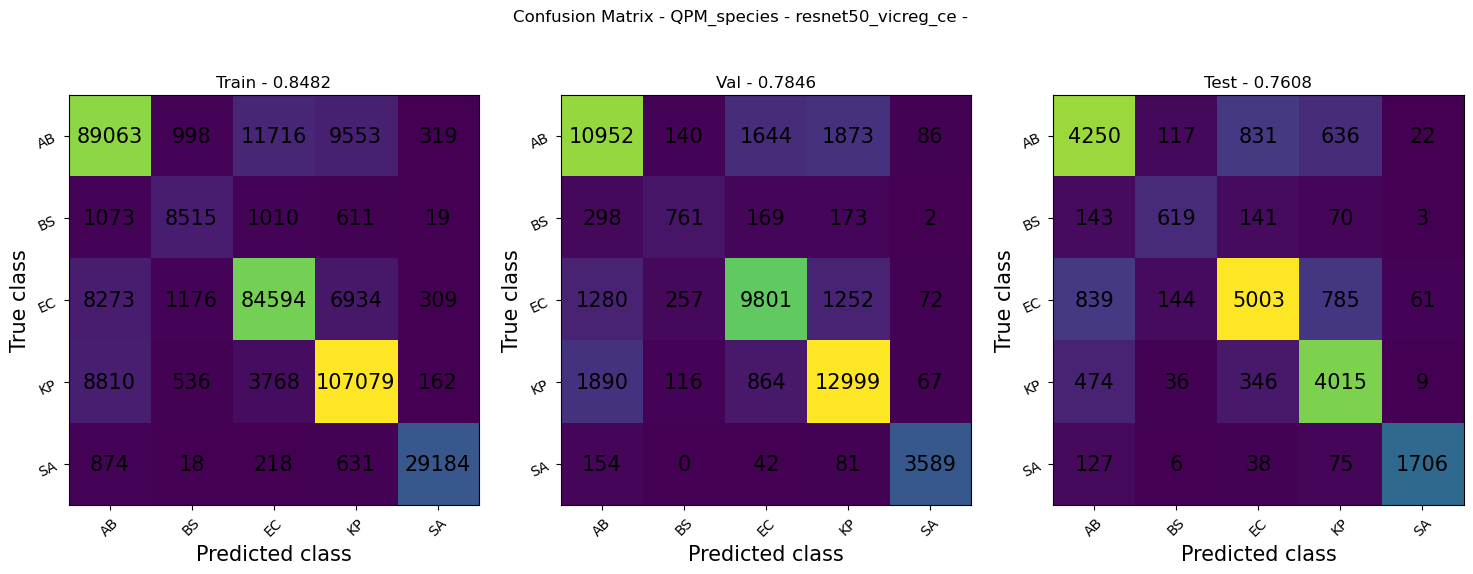

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


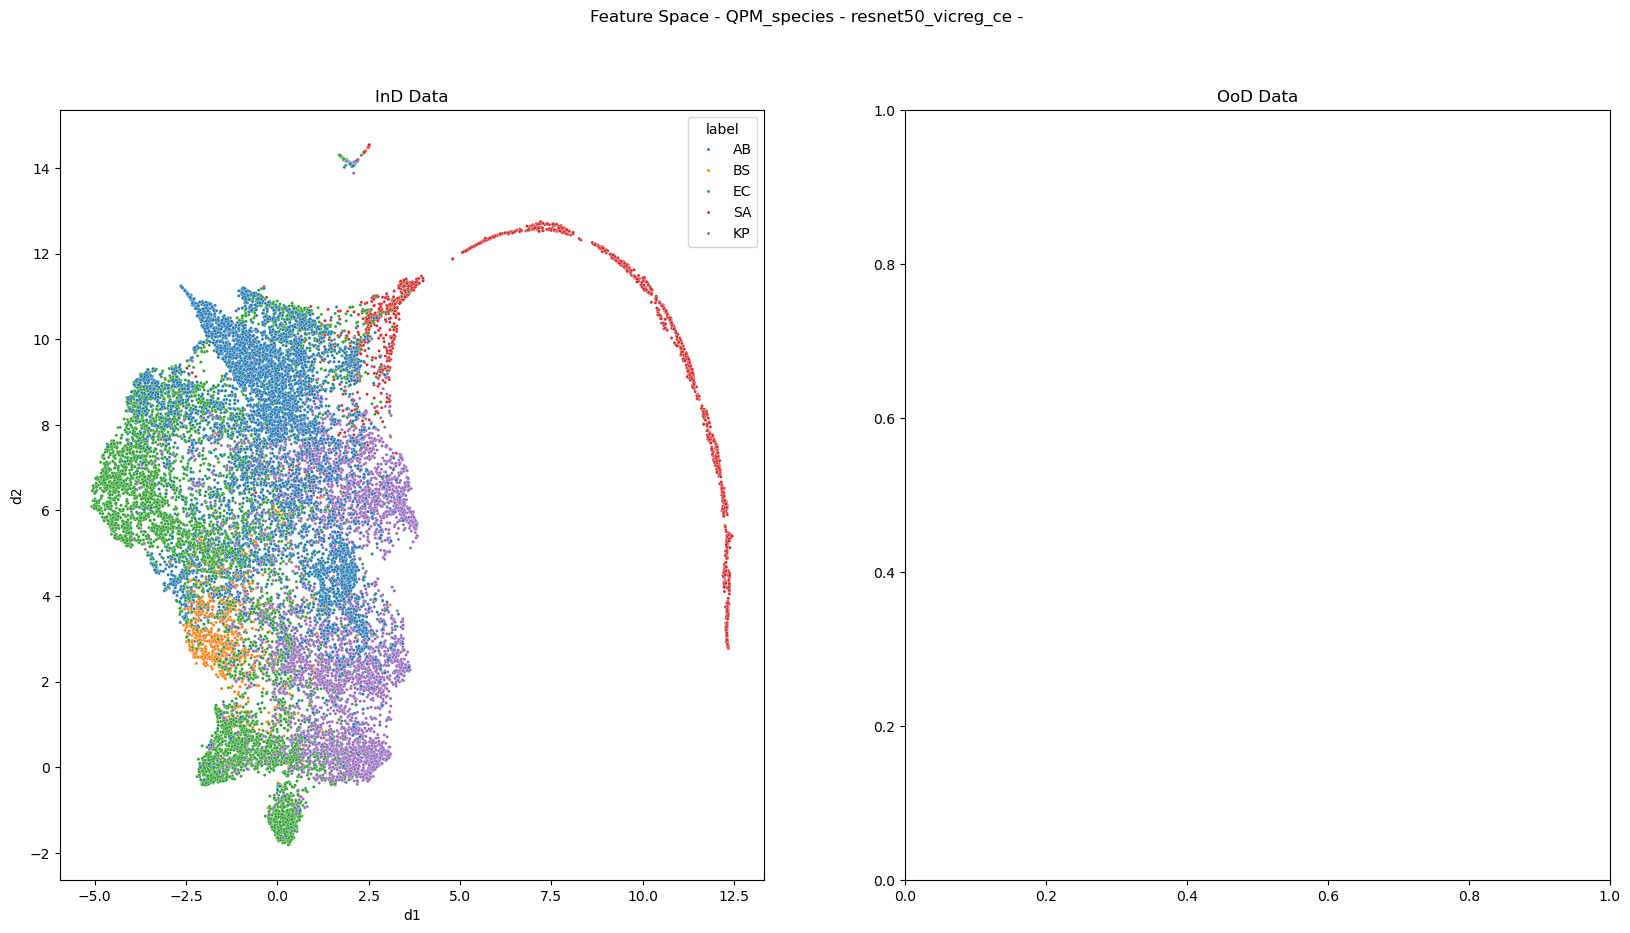

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

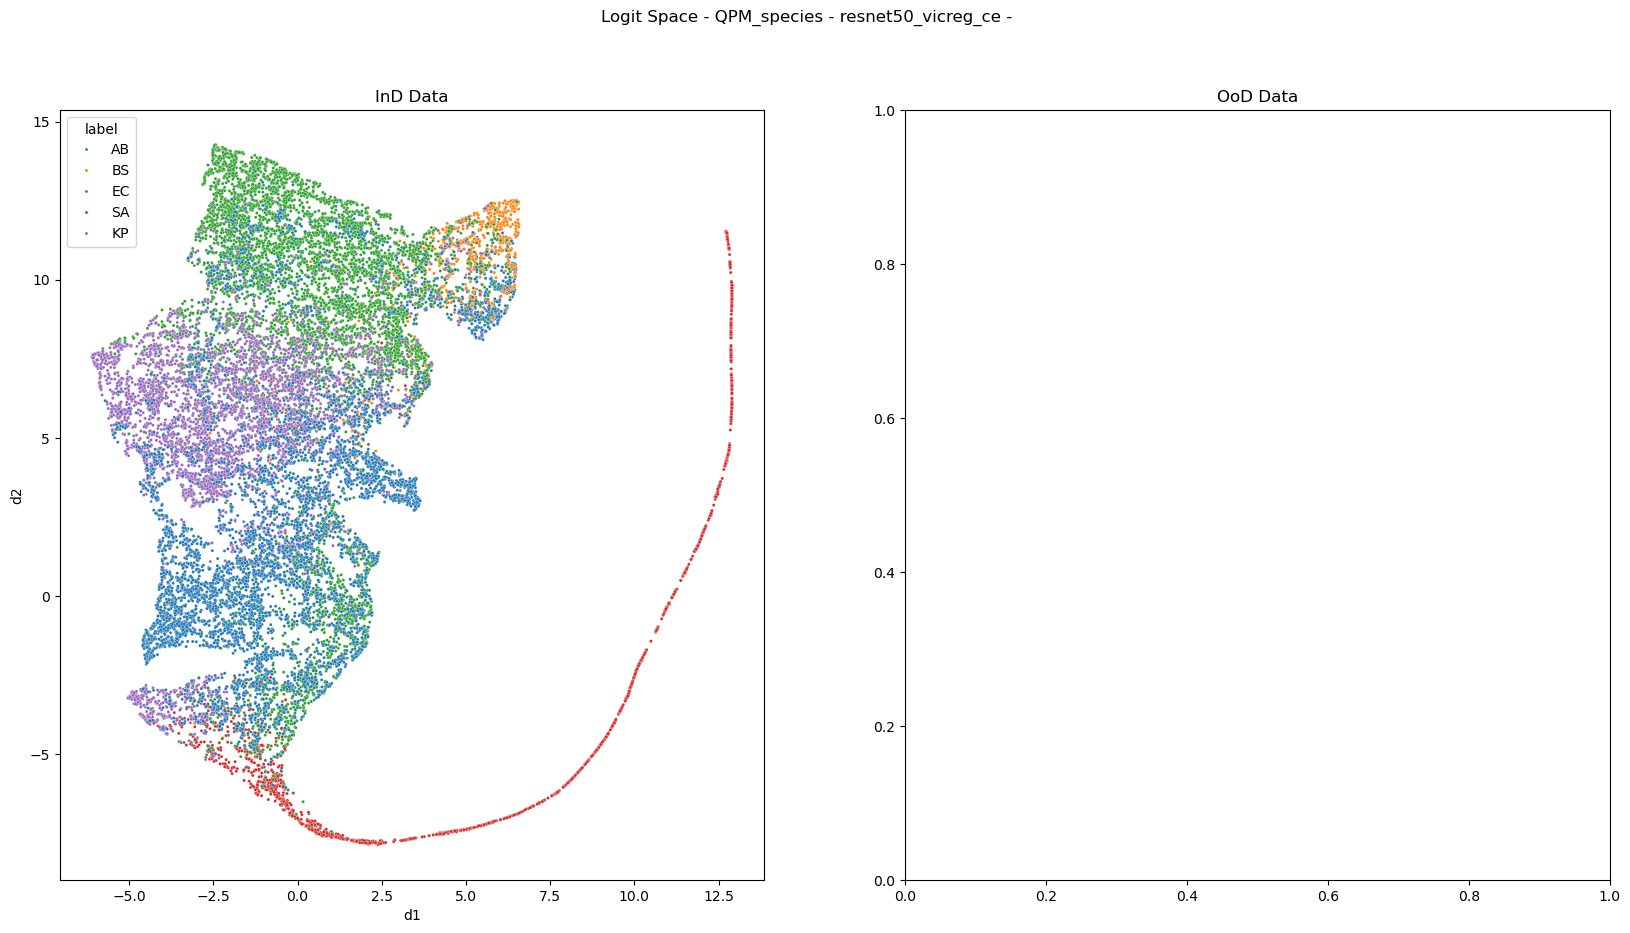

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

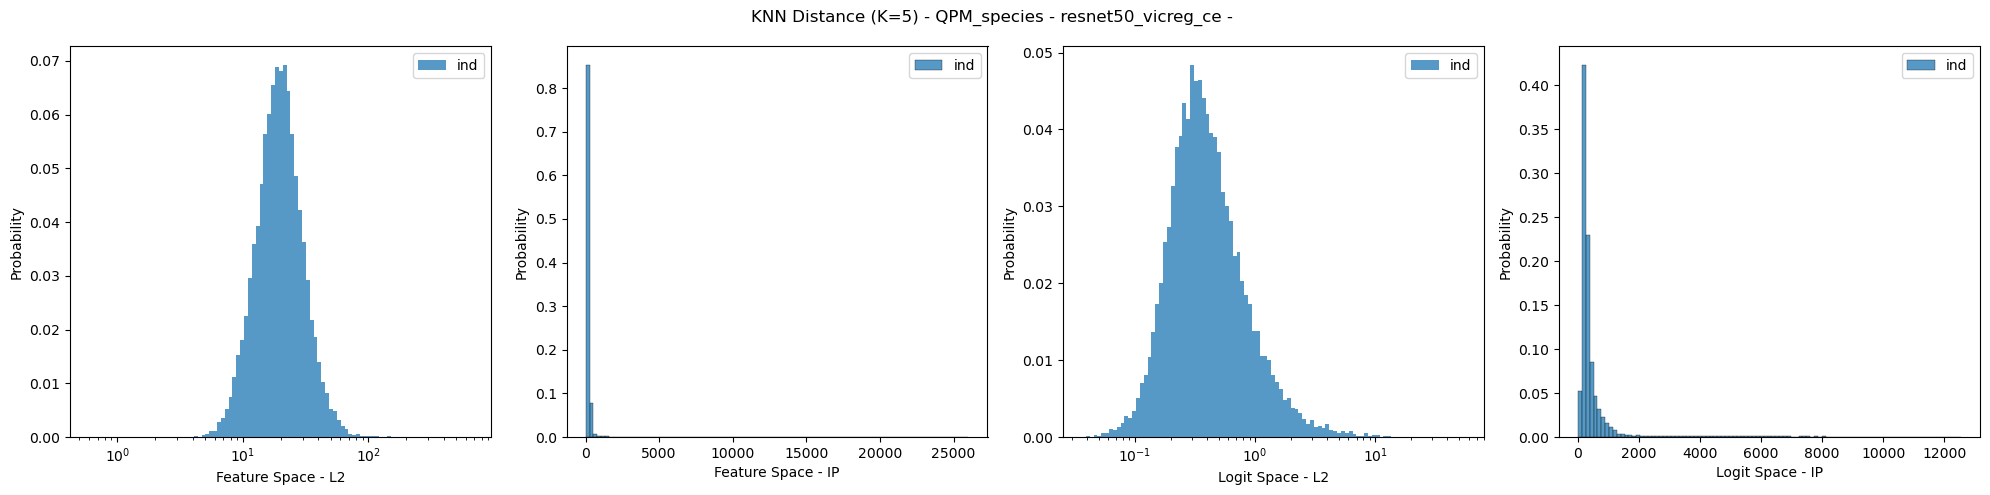

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

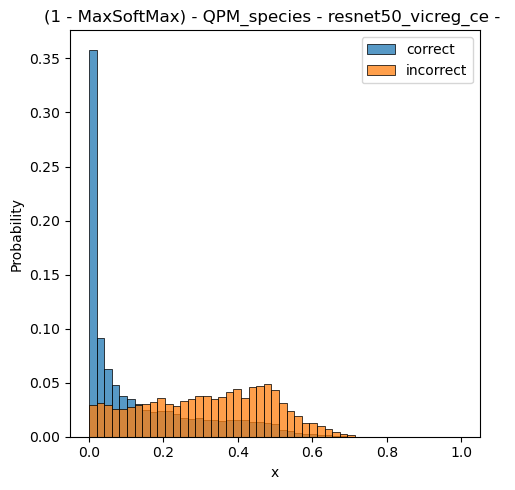

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)